# Portfolio Management using the Efficient Frontier


In this project, we will conduct a top-down analysis; however, macroeconomic factors such as the inflation rate will be omitted for convenience. Hence, we will proceed through the following pipeline:

1. Perform an industry analysis based on the sector ETFs' performance over the past three years.
2. Select sectors that have the following traits for further investigation of assets within those sectors:
    - Exhibit positive risk-adjusted performance 
    - Low correlation between asset classes  
3. If investing in an individual asset rather than a sector ETF yields a better risk-adjusted return, substitute the ETF with the individual asset in the portfolio.
4. Optimize the efficient frontier to determine the optimal weights of the asset classes.


Only sector indexes will be used in portfolio management, including:

- XLE: Energy Select Sector SPDR Fund
    - EXXON MOBIL CORP (XOM)
    - CHEVRON CORP (CVX)
- XLF: Financial Select Sector SPDR Fun
    - Berkshire Hathaway Inc. Class B (BRK.B)
    - JPMorgan Chase & Co. (JPM)
- XLU: Utilities Select Sector SPDR Fund
    - Exelon Corp (EXC)
    - Xcel Energy Inc (XEL)
- XLK: Technology Select Sector SPDR Fund
    - Microsoft Corporation (MSFT)
    - Apple Inc. (AAPL)
- XLV: Health Care Select Sector SPDR Fund
    - Pfizer Inc. (PFE)
    - Thermo Fisher Scientific Inc. (TMO)
- XLY: Consumer Discretionary Select Sector SPDR Fund
    - Amazon.com Inc (AMZN)
    - Home Depot Inc (HD)
- XLP: Consumer Staples Select Sector SPDR Fund
    - COCA COLA CO (KO)
    - COSTCO WHOLESALE CORP	(COST)
- GLD: SPDR Gold Shares





In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd /content/drive/MyDrive/Github_Commit/MPT

/content/drive/MyDrive/Github_Commit/MPT


In [8]:
!git config --global user.email 'victorius918@gmail.com'
!git config --global user.name 'HyunminHong'

In [ ]:
import yfinance as yf
from pandas_datareader import data as pdr
import scipy.stats
from sklearn.linear_model import LinearRegression
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import mpl, plt 
plt.style.use('seaborn') 
mpl.rcParams['font.family'] = 'serif' 
%matplotlib inline
yf.pdr_override()

<ipython-input-2-4e498f5b1119>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
# observation_period denotes the number of years to conduct the analysis
observation_period = 3

# Note that if the trading period is daily, then 252. the trading period is weekly, then 52. 
# We assume we trade daily in this analysis
trading_period = 252 

# n years of panel data
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*observation_period) 

# Use 10-year U.S. Treasury yield as a proxy for the risk-free rate
Rf = pdr.get_data_fred('GS10', start=startDate, end=endDate).mean()

# Use the following sector ETFs 
tickers_sector = ['XLE', 'XLF', 'XLU', 'XLK', 'XLV', 'XLY', 'XLP', 'GLD']

# Use SPY as the market 
ticker_market = ['SPY']



In [ ]:
# Import sector data from yahoo finance
df_sector = pdr.get_data_yahoo(tickers_sector, start=startDate, end=endDate)
df_sector = df_sector['Adj Close']

# Import market data from yahoo finance
df_market = pdr.get_data_yahoo(ticker_market, start=startDate, end=endDate)['Adj Close']

# Converts DatetimeArray/Index to PeriodArray/Index.
#df.index = df.index.to_period('W') 
df_sector.columns = ['Gold', 'Energy', 'Financial', 'Technology', 'Staples', 'Utilities', 'Health Care', 'Discretionary']
df_market.columns = ['Market']

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
df_market.head()

Date
2020-05-26    285.695770
2020-05-27    289.946625
2020-05-28    289.411652
2020-05-29    290.701294
2020-06-01    291.876221
Name: Adj Close, dtype: float64

In [ ]:
df_sector.head()

,GLD,XLE,XLF,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,
2020-05-26,160.889999,34.377819,21.709738,93.835587,53.477562,51.816120,94.937859,120.218971
2020-05-27,161.179993,34.821129,22.651184,94.371017,54.282784,52.435909,95.921211,122.278755
2020-05-28,161.720001,33.847591,22.293432,94.186035,54.764057,53.985386,97.171898,120.794922
2020-05-29,162.910004,33.691135,22.039244,95.373711,54.819595,54.404644,98.346222,121.234207
2020-06-01,163.660004,34.282200,22.293432,95.344505,55.199062,55.051785,97.372383,122.386139


### Asset Returns
$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}}\approx \log(1 + P_t),\quad\quad \log R_t = \log P_t - \log P_{t-1}
$$

In [ ]:
def asset_return(df, log=False):
    if log == False: # 
        returns = df / df.shift(1) - 1
        returns.dropna(axis=0, how='any', inplace=True)
    else: # log returns
        returns = np.log(df) - np.log(df.shift(1))
        returns.dropna(axis=0, how='any', inplace=True)
    return returns

In [ ]:
rtn_sector = asset_return(df_sector, log=True)
rtn_market = asset_return(df_market, log=True)
rtn_sector.head()

,Gold,Energy,Financial,Technology,Staples,Utilities,Health Care,Discretionary
Date,,,,,,,,
2020-05-27,0.001801,0.012813,0.042451,0.005690,0.014945,0.011890,0.010305,0.016988
2020-05-28,0.003345,-0.028357,-0.015920,-0.001962,0.008827,0.029122,0.012954,-0.012209
2020-05-29,0.007331,-0.004633,-0.011468,0.012531,0.001014,0.007736,0.012012,0.003630
2020-06-01,0.004593,0.017392,0.011468,-0.000306,0.006898,0.011824,-0.009951,0.009457
2020-06-02,-0.006498,0.027509,0.007992,0.009350,0.002679,0.006436,0.005768,0.008499


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

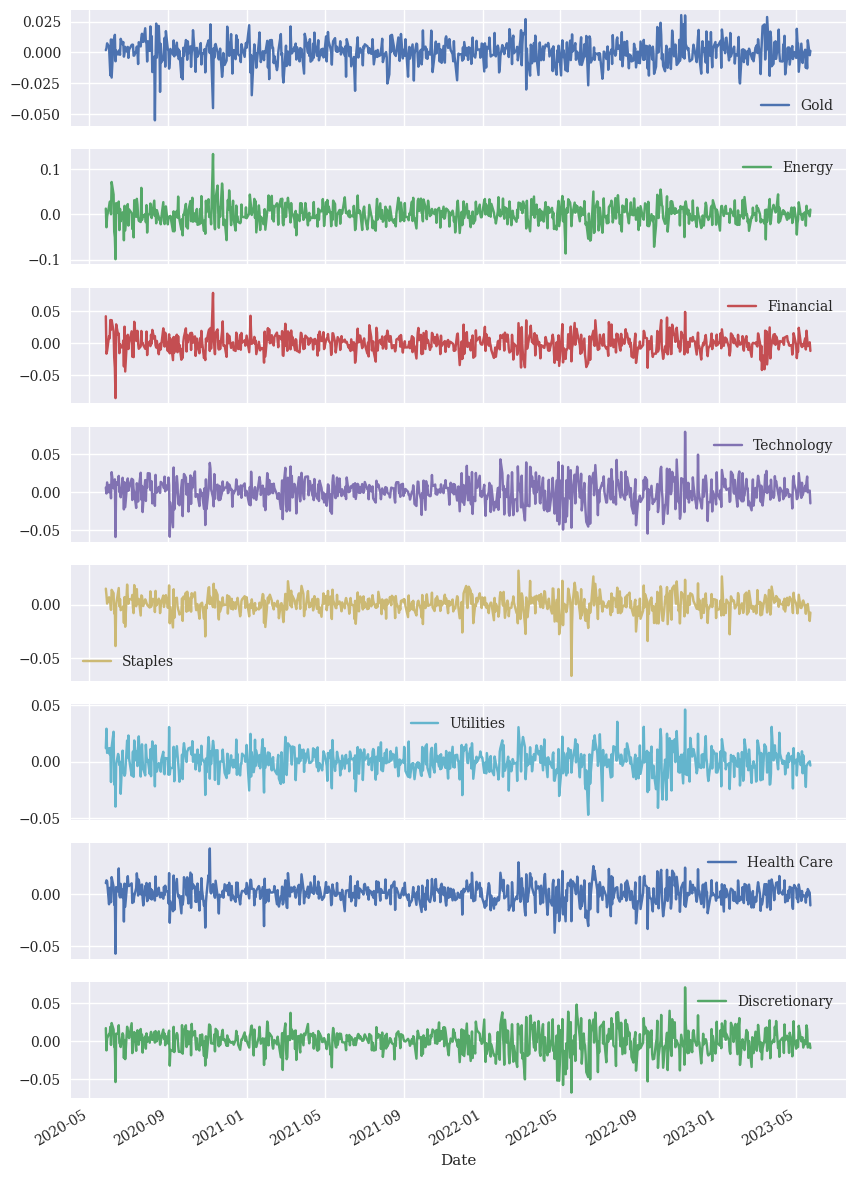

In [ ]:
rtn_sector.plot(subplots=True, figsize=(10, 16))

array([<Axes: xlabel='Date'>], dtype=object)

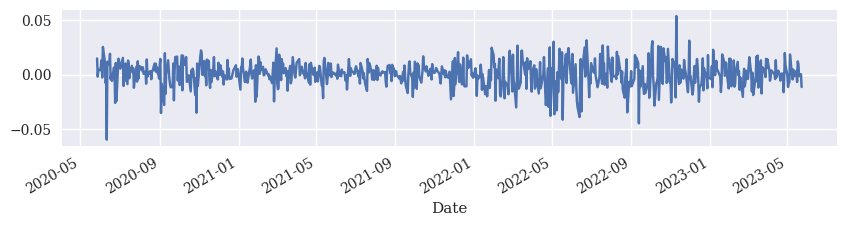

In [ ]:
rtn_market.plot(subplots=True, figsize=(10, 2))

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'Gold'),
  Text(0, 1.5, 'Energy'),
  Text(0, 2.5, 'Financial'),
  Text(0, 3.5, 'Technology'),
  Text(0, 4.5, 'Staples'),
  Text(0, 5.5, 'Utilities'),
  Text(0, 6.5, 'Health Care'),
  Text(0, 7.5, 'Discretionary')])

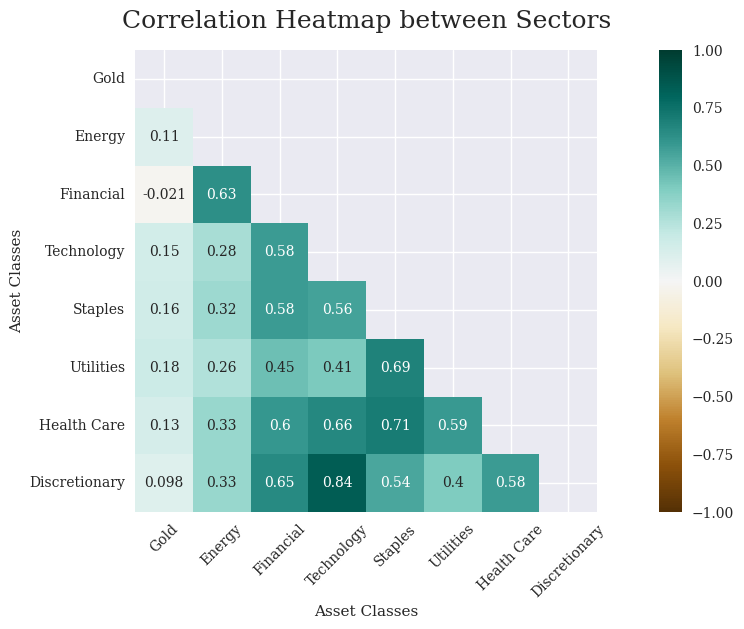

In [ ]:
plt.figure(figsize=(16, 6))

# Compute the correlation matrix
corr_sector = rtn_sector.corr()

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_sector, dtype=bool))

# Create a triangular correlation heatmap
heatmap = sns.heatmap(corr_sector, mask=mask, annot=True, cmap='BrBG',
                      vmin=-1, vmax=1, square=True)

# Set the title and axis labels
heatmap.set_title('Correlation Heatmap between Sectors', fontdict={'fontsize': 18}, pad=16)
plt.xlabel('Asset Classes')
plt.ylabel('Asset Classes')

# Rotate the tick labels for better visibility
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Relative Performance by Sectors

<Axes: xlabel='Date'>

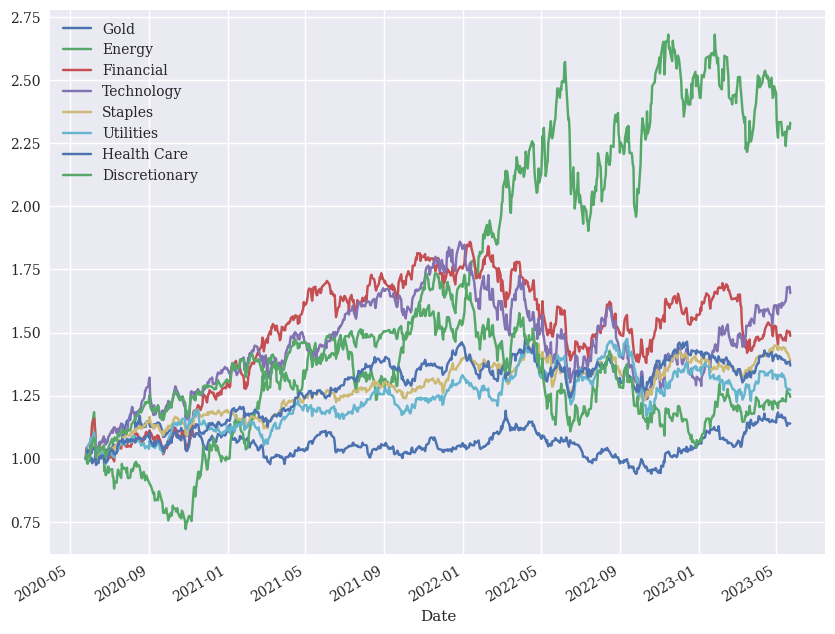

In [ ]:
# Normalized prices to measure the relative performance by sectors
normPrices = df_sector / df_sector.iloc[0]
normPrices.plot(figsize=(10, 8))

# Sharpe ratio vs. Sortino ratio

- **Sharpe ratio** is preferred to evaluate low-volatility investment portfolios
- **Sortino ratio** is preferred to evaluate high-volatility investment portfolios

In [ ]:
stats = pd.DataFrame()

# MDD computation requires to know the previous peaks
drawdown = (df_sector - df_sector.cummax()) / df_sector.cummax()
MDD = -(drawdown.min())*100

# We use log returns instead of returns for convenience
returns_annual = rtn_sector.mean()*trading_period*100
volatility_annual = rtn_sector.std(ddof=0)*np.sqrt(trading_period)*100
semi_std = rtn_sector[rtn_sector < 0].std(ddof=0)*np.sqrt(trading_period)*100

stats['Annualized Returns(%)'] = returns_annual.round(3)
stats['Annualized Volatility(%)'] = volatility_annual.round(3)
stats['Sharpe Ratio'] = (np.subtract(returns_annual, float(Rf))/volatility_annual)
stats['Sortino Ratio'] = (np.subtract(returns_annual, float(Rf))/semi_std) # preferred to evaluate high-volatility portfolios
stats['Maximum Drawdown(%)'] = MDD.round(3)

stats

,Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio,Sortino Ratio,Maximum Drawdown(%)
Gold,4.382,15.261,0.151594,0.204655,22.002
Energy,28.295,34.763,0.754453,1.170412,39.123
Financial,13.258,23.099,0.484418,0.732736,25.805
Technology,16.871,25.802,0.573690,0.845558,33.559
Staples,10.955,14.257,0.623294,0.810361,16.302
Utilities,8.036,18.416,0.324018,0.478791,20.716
Health Care,10.505,15.848,0.532317,0.771951,16.061
Discretionary,7.330,25.376,0.207338,0.285307,39.670


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8')])

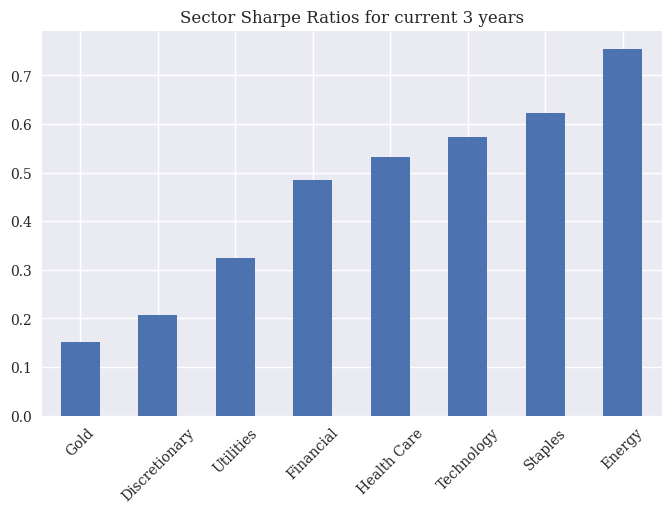

In [ ]:
stats['Sharpe Ratio'].sort_values().plot.bar(title='Sector Sharpe Ratios for current {} years'.format(observation_period), 
                                             figsize=(8,5))
plt.xticks(rotation=45)
plt.yticks(rotation=0)


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2'),
  Text(0, 1.4000000000000001, '1.4')])

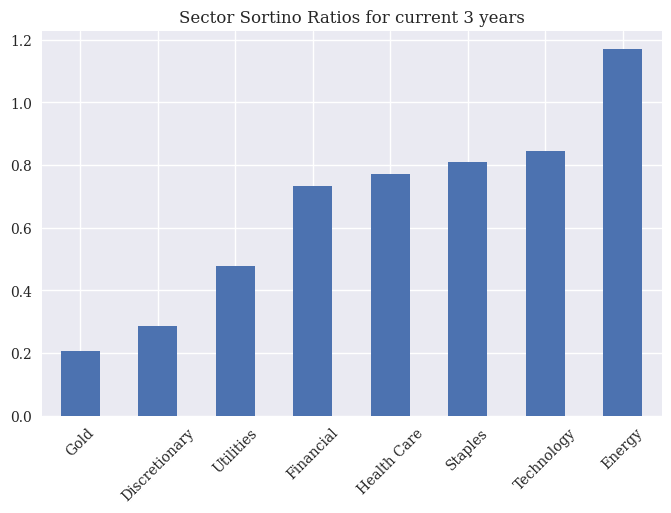

In [ ]:
stats['Sortino Ratio'].sort_values().plot.bar(title='Sector Sortino Ratios for current {} years'.format(observation_period), 
                                             figsize=(8,5))
plt.xticks(rotation=45)
plt.yticks(rotation=0)

In [ ]:
def beta_market(returns, returns_market):
    if isinstance(returns, pd.DataFrame):
        for i in returns.columns:
            beta = pd.DataFrame()
            beta[i] = np.cov(returns_market, returns[i])[0][1] / np.var(returns_market)
    
    else:
        raise TypeError("Not allowed data type")
    return beta

In [ ]:
rtn_sector.columns

Index(['Gold', 'Energy', 'Financial', 'Technology', 'Staples', 'Utilities',
       'Health Care', 'Discretionary'],
      dtype='object')

In [ ]:
betas = pd.DataFrame()
betas[rtn_sector.columns[0]] = np.cov(rtn_market, rtn_sector[0])[0][1] / np.var(rtn_market)

KeyError: ignored

In [ ]:
betas = beta_market(rtn_sector, rtn_market)
betas

,Discretionary


In [ ]:
np.var(rtn_market)

0.00014016633017227998

In [ ]:
bbeta_market(rtn_sector, rtn_market)

IndexError: ignored

In [ ]:
def skewness(returns):
    demeaned_returns = returns - returns.mean()
    std = returns.std(ddof=0)
    return (demeaned_returns**3).mean() / std**3

def kurtosis(returns):
    demeaned_returns = returns - returns.mean()
    std = returns.std(ddof=0)
    return (demeaned_returns**4).mean() / std**4

In [ ]:
skewness(rtn)

Gold            -0.531514
Energy           0.044087
Financial       -0.087776
Technology      -0.183934
Staples         -0.818193
Utilities       -0.228101
Health Care     -0.366624
Discretionary   -0.374634
dtype: float64

In [ ]:
kurtosis(rtn)

Gold             5.477568
Energy           5.320722
Financial        5.641695
Technology       4.173166
Staples          7.851271
Utilities        3.849893
Health Care      5.129184
Discretionary    4.432541
dtype: float64

In [ ]:
scipy.stats.kurtosis(rtn) # giving an excess kurtosis

array([2.47756844, 2.32072199, 2.64169495, 1.17316621, 4.85127053,
       0.84989331, 2.12918436, 1.43254058])

In [ ]:
scipy.stats.skew(rtn)

array([-0.53151362,  0.04408655, -0.08777643, -0.18393379, -0.81819332,
       -0.22810098, -0.36662398, -0.37463352])

In [ ]:
scipy.stats.jarque_bera(rtn)

SignificanceResult(statistic=3959.2935555485187, pvalue=0.0)

In [ ]:
def isNormal(returns, alpha=0.01):
    """
    Using Jarque Bera test to determine whether the given returns are normally distributed or not.
    H0: the data in vector x comes from a normal distribution with an unknown mean and variance
    H1: the data is not from such distribution
    """
    testStat, pVal = scipy.stats.jarque_bera(returns)
    return pVal > alpha

In [ ]:
rtn.aggregate(isNormal) # based on the result, all sectors are not normally distributed

Gold             False
Energy           False
Financial        False
Technology       False
Staples          False
Utilities        False
Health Care      False
Discretionary    False
dtype: bool

In [ ]:
rtn[rtn.columns[0]]

Date
2020-05-27    0.001801
2020-05-28    0.003345
2020-05-29    0.007331
2020-06-01    0.004593
2020-06-02   -0.006498
                ...   
2023-05-17   -0.003468
2023-05-18   -0.013058
2023-05-19    0.009850
2023-05-22   -0.002344
2023-05-23    0.001200
Name: Gold, Length: 754, dtype: float64

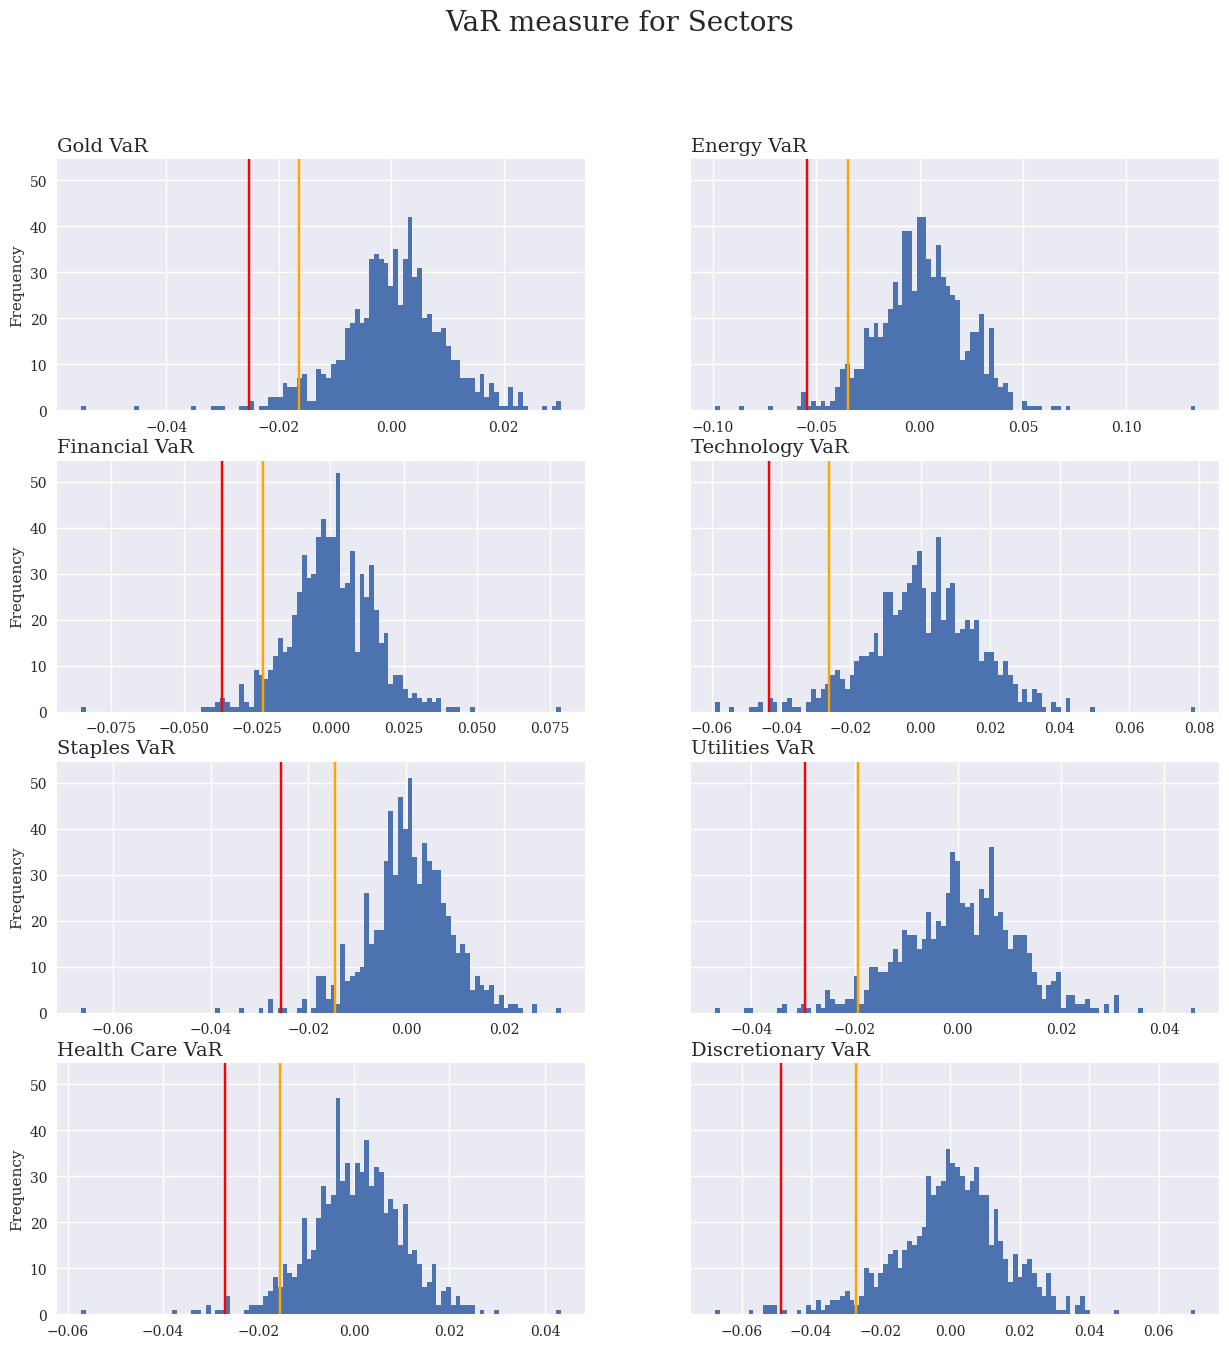

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15), sharey=True)
fig.suptitle('VaR measure for Sectors', fontsize=20)

const = 0
for i in range(len(axes)):
    for j in range(len(axes[0])):
        axes[i][j] = rtn[rtn.columns[const]].plot(kind='hist', bins=100, ax=axes[i][j])
        axes[i][j].axvline(np.percentile(rtn[rtn.columns[const]], 5), color='orange', label='5%')
        axes[i][j].axvline(np.percentile(rtn[rtn.columns[const]], 1), color='red', label='1%')
        axes[i][j].set_title('{} VaR '.format(rtn.columns[const]), loc='left', fontsize=14)
        const += 1

# VaR and CVaR

- Historical VaR
- Parametric VaR
- Modified Conish-Fisher VaR

In [ ]:
type(np.percentile(rtn, 5, axis=0))

numpy.ndarray

In [ ]:
def varHistoric(returns, alpha=5):
    """
    VaR Historic
    """
    if isinstance(returns, pd.DataFrame):
        return returns.aggregate(varHistoric, alpha=alpha)
    elif isinstance(returns, pd.Series):
        return -np.percentile(returns, alpha)
    else:
        raise TypeError("Not allowed data type")

In [ ]:
varHistoric(rtn)

Gold             0.016416
Energy           0.034517
Financial        0.023032
Technology       0.026331
Staples          0.014581
Utilities        0.019346
Health Care      0.015512
Discretionary    0.027204
dtype: float64

In [ ]:
def varGaussian(returns, alpha=5, modified=False):
    z = scipy.stats.norm.ppf(alpha/100)

    if modified:
        s = scipy.stats.skew(returns)
        k = scipy.stats.kurtosis(returns) + 3
        z = (z + (z**2 - 1)*s/6 + (z**3 - 3*z)*(k-3)/24 - (2*z**3 - 5*z)*(s**2)/36)
        
    return -(returns.mean() + z*returns.std(ddof=0))

In [ ]:
k = scipy.stats.kurtosis(rtn) + 3
k

array([5.47756844, 5.32072199, 5.64169495, 4.17316621, 7.85127053,
       3.84989331, 5.12918436, 4.43254058])

In [ ]:
varGaussian(rtn, modified=True)

Gold             0.016559
Energy           0.033596
Financial        0.022993
Technology       0.026520
Staples          0.015434
Utilities        0.019305
Health Care      0.016591
Discretionary    0.027201
dtype: float64

<Axes: title={'center': 'VaR: Sectors'}>

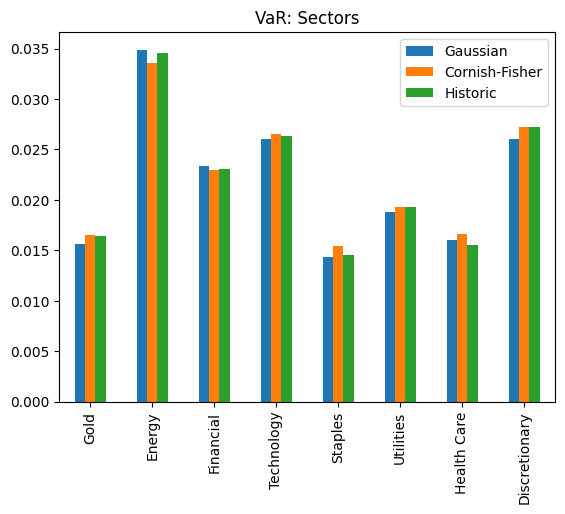

In [ ]:
var_list = [varGaussian(rtn), varGaussian(rtn, modified=True), varHistoric(rtn)]
comparision = pd.concat(var_list, axis=1)
comparision.columns = ['Gaussian', 'Cornish-Fisher', 'Historic']
comparision.plot.bar(title="VaR: Sectors")

In [ ]:
def cvarHistoric(returns, alpha=5):
    """
    CVaR Historic
    """
    if isinstance(returns, pd.Series):
        is_beyond = returns <= -varHistoric(returns, alpha=alpha)
        return -returns[is_beyond].mean()
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(cvarHistoric, alpha=alpha)
    else:
        raise TypeError("Not allowed data type")

# Efficient Frontier

In [ ]:
annualized_rtn = stats['Annualized Returns(%)']

<Axes: >

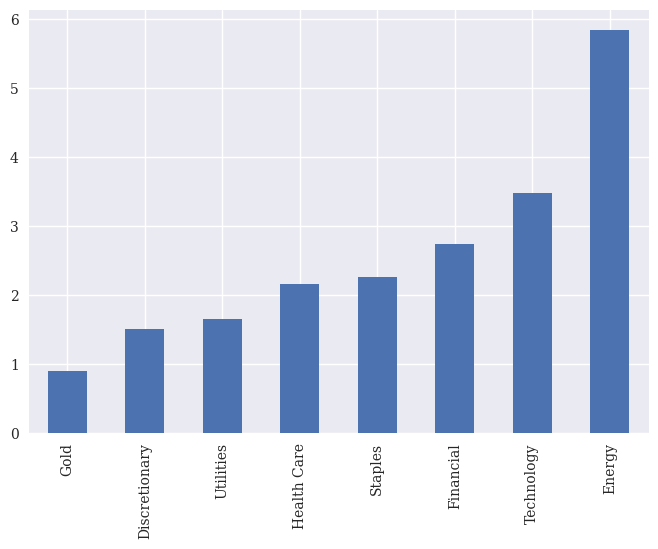

In [ ]:
annualized_rtn.sort_values().plot.bar()

In [ ]:
cov = rtn.cov()
cov

,Gold,Energy,Financial,Technology,Staples,Utilities,Health Care,Discretionary
Gold,0.000093,0.000023,-0.000003,0.000024,0.000014,0.000020,0.000013,0.000015
Energy,0.000023,0.000480,0.000202,0.000101,0.000063,0.000066,0.000072,0.000115
Financial,-0.000003,0.000202,0.000212,0.000137,0.000076,0.000076,0.000087,0.000151
Technology,0.000024,0.000101,0.000137,0.000265,0.000082,0.000077,0.000108,0.000219
Staples,0.000014,0.000063,0.000076,0.000082,0.000081,0.000071,0.000064,0.000078
Utilities,0.000020,0.000066,0.000076,0.000077,0.000071,0.000135,0.000068,0.000075
Health Care,0.000013,0.000072,0.000087,0.000108,0.000064,0.000068,0.000100,0.000093
Discretionary,0.000015,0.000115,0.000151,0.000219,0.000078,0.000075,0.000093,0.000256
